## Import

In [2]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import matplotlib.pyplot as plt


In [3]:
class ImageMaskDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.images = [f for f in os.listdir(image_dir) if f.endswith('.jpg')]
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_name = self.images[idx]
        img_path = os.path.join(self.image_dir, img_name)
        mask_path = os.path.join(self.mask_dir, img_name.replace('.jpg', '_mask.png'))  # 확장자를 .png로 설정

        image = Image.open(img_path).convert('RGB')
        mask = Image.open(mask_path).convert('L')  # 마스크 이미지는 흑백으로 변환

        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)

        return image, mask


In [4]:
# 하이퍼 파라미터
image_height = 224
image_width = 224
batch_size = 32
epochs = 30
learning_rate = 1e-4
backbone_model = 'mobilenet_v2' 


In [5]:
# 데이터 경로 설정
train_image_dir = '/home/hdd3/lee_hw/Hadoop_project/Front_data/origin_data/train_origin'
train_mask_dir = '/home/hdd3/lee_hw/Hadoop_project/Front_data/masking_data/train_mask'
validation_image_dir = '/home/hdd3/lee_hw/Hadoop_project/Front_data/origin_data/valid_origin'
validation_mask_dir = '/home/hdd3/lee_hw/Hadoop_project/Front_data/masking_data/valid_mask'

In [6]:
from torchvision import transforms

# 데이터 변환 설정
transform = transforms.Compose([
    transforms.Resize((image_height, image_width)),
    transforms.ToTensor() #정규화 수행
])

In [7]:
from torch.utils.data import DataLoader


#데이터 로더 설정
train_dataset = ImageMaskDataset(train_image_dir, train_mask_dir, transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

valid_dataset = ImageMaskDataset(validation_image_dir, validation_mask_dir, transform)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)


In [8]:
import segmentation_models_pytorch as smp

# 모델 설정
model = smp.Unet(encoder_name=backbone_model, 
                 encoder_weights='imagenet', 
                 classes=1, 
                 activation='sigmoid')
model = model.to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))


In [9]:
import segmentation_models_pytorch as smp
import torch.optim as optim

# 이진 분류 문제의 손실 함수 설정
criterion = smp.losses.DiceLoss(mode='binary')

# 옵티마이저 설정
optimizer = optim.Adam(model.parameters(), lr=learning_rate)


In [10]:
# device 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [11]:
def iou(outputs, labels):
    outputs = (outputs > 0.5).float()  # 출력을 이진 마스크로 만들기 위해 임계값 적용
    labels = labels.float()
    intersection = (outputs * labels).sum()  # 교집합
    union = (outputs + labels - outputs * labels).sum()  # 합집합

    return (intersection + 1e-6) / (union + 1e-6)

def dice_coefficient(outputs, labels):
    outputs = (outputs > 0.5).float()  # 출력을 이진 마스크로 만들기 위해 임계값 적용
    labels = labels.float()
    intersection = (outputs * labels).sum()
    total = outputs.sum() + labels.sum()
    
    return (2. * intersection + 1e-6) / (total + 1e-6)


In [12]:
# 학습 루프
train_loss_list = []
valid_loss_list = []
train_iou_list = []
valid_iou_list = []
train_dice_list = []
valid_dice_list = []

for epoch in range(epochs):
    model.train()
    train_loss = 0
    train_iou = 0
    train_dice = 0
    for images, masks in train_loader:
        images = images.to(device)
        masks = masks.to(device)
        outputs = model(images)
        loss = criterion(outputs, masks)
        train_loss += loss.item()
        train_iou += iou(outputs, masks)
        train_dice += dice_coefficient(outputs, masks)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    train_loss /= len(train_loader)
    train_iou /= len(train_loader)
    train_dice /= len(train_loader)
    train_loss_list.append(train_loss)
    train_iou_list.append(train_iou)
    train_dice_list.append(train_dice)

    model.eval()
    valid_loss = 0
    valid_iou = 0
    valid_dice = 0
    with torch.no_grad():
        for images, masks in valid_loader:
            images = images.to(device)
            masks = masks.to(device)
            outputs = model(images)
            loss = criterion(outputs, masks)
            valid_loss += loss.item()
            valid_iou += iou(outputs, masks)
            valid_dice += dice_coefficient(outputs, masks)

    valid_loss /= len(valid_loader)
    valid_iou /= len(valid_loader)
    valid_dice /= len(valid_loader)
    valid_loss_list.append(valid_loss)
    valid_iou_list.append(valid_iou)
    valid_dice_list.append(valid_dice)

    print(f'Epoch {epoch+1}/{epochs}, Training Loss: {train_loss}, Validation Loss: {valid_loss}, Training IOU: {train_iou}, Validation IOU: {valid_iou}, Training Dice: {train_dice}, Validation Dice: {valid_dice}')


/home/lee_hw/anaconda3/envs/hw/lib/python3.10/site-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


Epoch 1/30, Training Loss: 0.813240985903475, Validation Loss: 0.800558015704155, Training IOU: 0.3274144232273102, Validation IOU: 0.37072330713272095, Training Dice: 0.4861396253108978, Validation Dice: 0.5393712520599365
Epoch 2/30, Training Loss: 0.8011201028194692, Validation Loss: 0.7950408657391866, Training IOU: 0.4569460451602936, Validation IOU: 0.46820634603500366, Training Dice: 0.6238341331481934, Validation Dice: 0.6362926959991455
Epoch 3/30, Training Loss: 0.7973346536358198, Validation Loss: 0.7929637167188857, Training IOU: 0.5201368927955627, Validation IOU: 0.5319899320602417, Training Dice: 0.6807816624641418, Validation Dice: 0.6930656433105469
Epoch 4/30, Training Loss: 0.7952574644651678, Validation Loss: 0.7915947867764367, Training IOU: 0.5583863854408264, Validation IOU: 0.5592957139015198, Training Dice: 0.7140753865242004, Validation Dice: 0.7159452438354492
Epoch 5/30, Training Loss: 0.7938847719795175, Validation Loss: 0.7908392631345325, Training IOU: 0.

: 

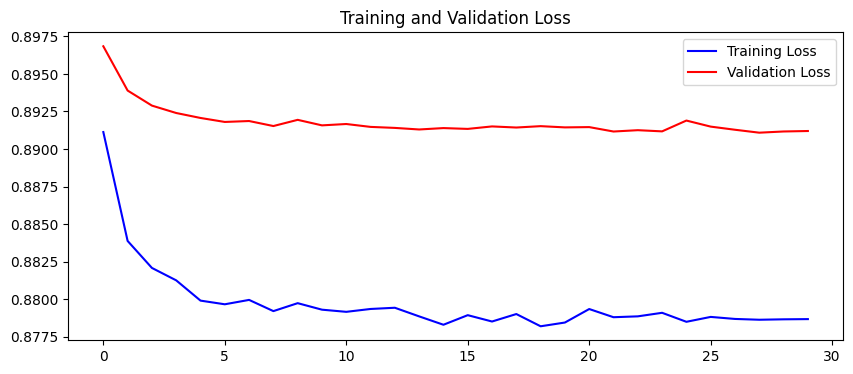

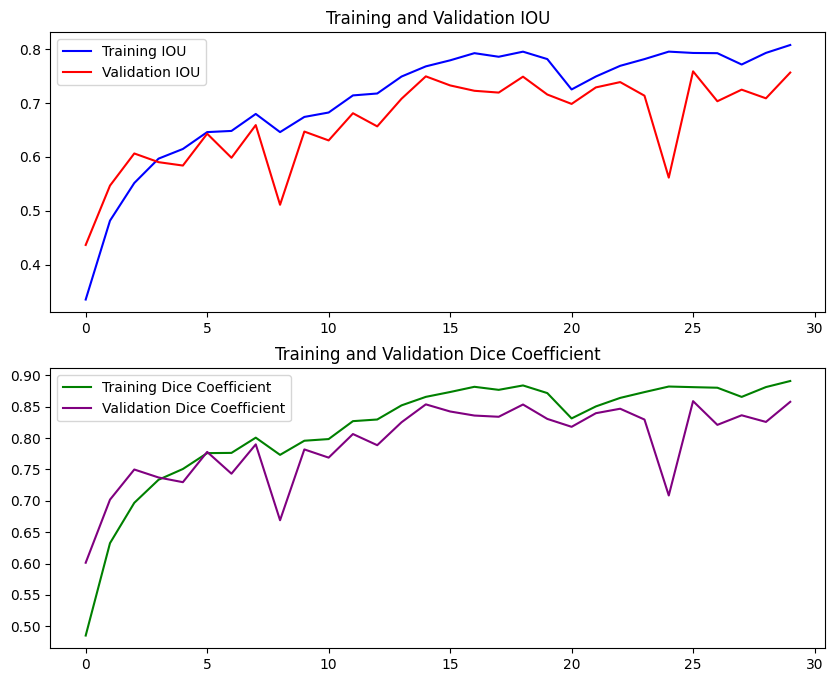

: 

In [12]:
import matplotlib.pyplot as plt

# loss 시각화
plt.figure(figsize=(10, 4))
plt.plot(train_loss_list, label='Training Loss', color='blue')  # 훈련 손실을 파란색으로 표시
plt.plot(valid_loss_list, label='Validation Loss', color='red')  # 검증 손실을 빨간색으로 표시
plt.title('Training and Validation Loss')
plt.legend()

# IOU 시각화
plt.figure(figsize=(10, 8))
plt.subplot(2, 1, 1)
plt.plot([x.item() for x in train_iou_list], label='Training IOU', color='blue')  # 텐서에서 숫자로 변환
plt.plot([x.item() for x in valid_iou_list], label='Validation IOU', color='red')  # 텐서에서 숫자로 변환
plt.title('Training and Validation IOU')
plt.legend()

# Dice Coefficient 시각화
plt.subplot(2, 1, 2)
plt.plot([x.item() for x in train_dice_list], label='Training Dice Coefficient', color='green')  # 텐서에서 숫자로 변환
plt.plot([x.item() for x in valid_dice_list], label='Validation Dice Coefficient', color='purple')  # 텐서에서 숫자로 변환
plt.title('Training and Validation Dice Coefficient')
plt.legend()

plt.show()


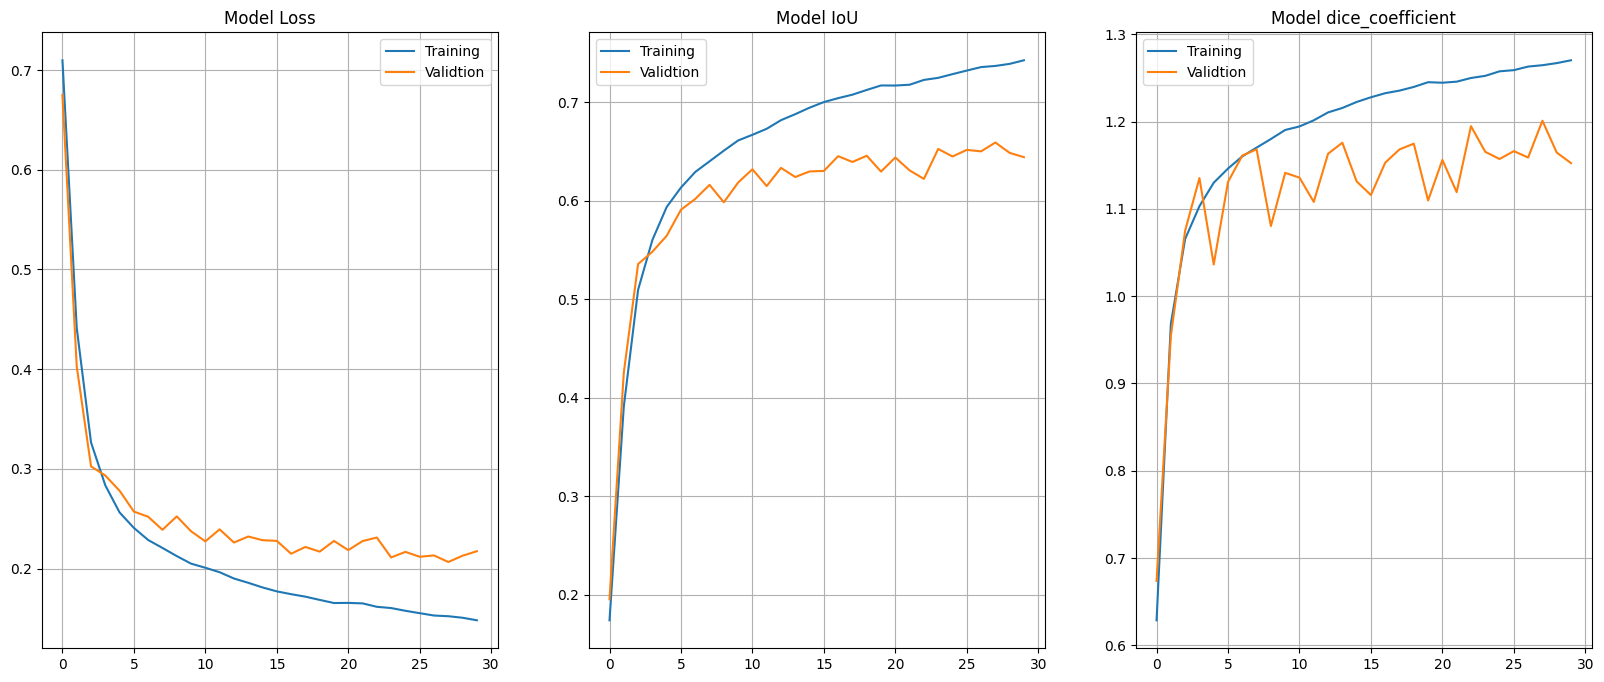

In [25]:
#모델 저장
torch.save(model.state_dict(), './model_for_img_selection.pth')
